<a href="https://colab.research.google.com/github/gurer1hsn/Sanatturleri/blob/main/BERT_ve_T5_Kar%C5%9F%C4%B1la%C5%9Ft%C4%B1rmas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Transformers: Hugging Face modelleri için
# Datasets: Hazır veri setlerini kolayca yüklemek için
# scikit-learn: Accuracy ve F1-score gibi metrikler için
!pip install transformers datasets scikit-learn -q


In [ ]:
import torch
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    T5Tokenizer, T5ForConditionalGeneration,
    Trainer, TrainingArguments,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# GPU varsa onu kullanıyoruz, yoksa CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)


Kullanılan cihaz: cpu


In [ ]:
from datasets import load_dataset

# Veri kümelerini Hugging Face'ten yükle
imdb = load_dataset("imdb")
emotion = load_dataset("dair-ai/emotion")

# Emotion etiketlerini yazdır
print("Emotion etiketleri:", emotion["train"].features["label"].names)


Emotion etiketleri: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [ ]:
# IMDB eğitim verisini %80 eğitim, %20 doğrulama olarak bölüyoruz
imdb_split = imdb["train"].train_test_split(test_size=0.2, seed=42)
imdb_train = imdb_split["train"]
imdb_valid = imdb_split["test"]
imdb_test = imdb["test"]


In [ ]:
# GEREKLİ KÜTÜPHANELERİ İÇE AKTARIYORUZ
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset

# BERT MODELİNİ YÜKLÜYORUZ
bert_model_name = "bert-base-uncased"
tokenizer_bert = BertTokenizer.from_pretrained(bert_model_name)
model_bert = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Her metni tokenize ediyoruz (maksimum 256 token, padding yapılıyor)
def tokenize_bert(example):
    return tokenizer_bert(example["text"], padding="max_length", truncation=True, max_length=256)


In [ ]:
# Train, validation ve test verilerini tokenize ediyoruz
imdb_train_enc = imdb_train.map(tokenize_bert, batched=True)
imdb_valid_enc = imdb_valid.map(tokenize_bert, batched=True)
imdb_test_enc = imdb_test.map(tokenize_bert, batched=True)

# Verileri PyTorch tensör formatına çeviriyoruz (Trainer böyle bekliyor)
for ds in [imdb_train_enc, imdb_valid_enc, imdb_test_enc]:
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


In [ ]:
# Accuracy ve F1-score hesaplayan fonksiyon
def compute_metrics(pred):
    labels = pred.label_ids                      # Gerçek etiketler
    preds = pred.predictions.argmax(-1)          # Tahmin edilen sınıf
    acc = accuracy_score(labels, preds)          # Doğruluk
    f1 = f1_score(labels, preds, average="macro")# Makro F1
    return {"accuracy": acc, "f1": f1}


In [ ]:
from transformers import TrainingArguments

training_args_bert = TrainingArguments(
    output_dir="./bert-imdb",               # Modelin kaydedileceği klasör
    num_train_epochs=3,                     # Epoch sayısı
    per_device_train_batch_size=16,         # Batch size
    per_device_eval_batch_size=16,
    # evaluation_strategy="epoch",            # Her epoch sonunda doğrulama yap # Removed: This parameter is likely not supported in the current transformers version.
    # logging_strategy="epoch",               # Logları da her epoch sonunda göster # Removed: This parameter is likely not supported in the current transformers version.
    save_strategy="no",                     # Modeli her seferinde kaydetme
    report_to="none"                        # W&B gibi servislere gönderme
)

In [ ]:
from transformers import Trainer

trainer_bert = Trainer(
    model=model_bert,                       # BERT modeli
    args=training_args_bert,                # Eğitim ayarları
    train_dataset=imdb_train_enc,           # Eğitim verisi
    eval_dataset=imdb_valid_enc,            # Doğrulama verisi
    compute_metrics=compute_metrics         # Değerlendirme fonksiyonu
)


In [ ]:
# Modeli eğitiyoruz
num_train_epochs=1  # TrainingArguments içinde değiştir



In [ ]:
# İlk 100 veriyi seçiyoruz
small_test = imdb_test_enc.select(range(100))

# Modelin küçük test verisi üzerindeki performansını ölçüyoruz
results = trainer_bert.evaluate(small_test)

# Sonuçları yazdırıyoruz (accuracy, f1 gibi metrikler)
print(results)


{'eval_loss': 0.7246230244636536, 'eval_model_preparation_time': 0.0117, 'eval_accuracy': 0.13, 'eval_f1': 0.11504424778761062, 'eval_runtime': 109.9937, 'eval_samples_per_second': 0.909, 'eval_steps_per_second': 0.064}


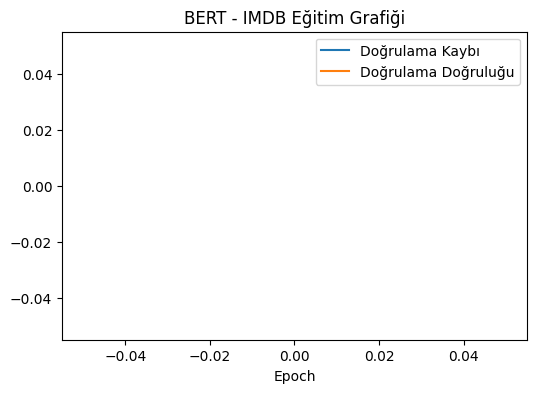

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Eğitim sırasında loglanan verileri DataFrame'e çeviriyoruz
logs = pd.DataFrame(trainer_bert.state.log_history)

# Sadece doğrulama (eval) satırlarını alıyoruz
logs = logs[logs["eval_loss"].notna()]

# Eğer epoch sütunu yoksa, dict içinden manuel çek
if "epoch" not in logs.columns:
    logs["epoch"] = [entry.get("epoch", None) for entry in trainer_bert.state.log_history if "eval_loss" in entry]

# Grafik çizimi
plt.figure(figsize=(6, 4))
plt.plot(logs["epoch"], logs["eval_loss"], label="Doğrulama Kaybı")
if "eval_accuracy" in logs.columns:
    plt.plot(logs["epoch"], logs["eval_accuracy"], label="Doğrulama Doğruluğu")
plt.title("BERT - IMDB Eğitim Grafiği")
plt.xlabel("Epoch")
plt.legend()
plt.show()


In [ ]:
t5_model_name = "t5-base"
tokenizer_t5 = T5Tokenizer.from_pretrained(t5_model_name)
model_t5 = T5ForConditionalGeneration.from_pretrained(t5_model_name)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# 0 -> "olumsuz", 1 -> "olumlu"
label_map = {0: "negative", 1: "positive"}

# T5 için metni giriş, etiketleri string olarak hedef olarak veriyoruz
def preprocess_t5(examples):
    input_texts = examples["text"]
   # Her örnek için 'etiket'in bir liste olup olmadığını kontrol edin ve eğer öyleyse, ilk öğeyi alın
    labels = [example_label[0] if isinstance(example_label, list) else example_label
              for example_label in examples["label"]]
    target_texts = [label_map[int(label)] for label in labels] # Etiketleri int'e dönüştür
    # Girdi metni tokenize edilir
    input_enc = tokenizer_t5(input_texts, max_length=256, padding="max_length", truncation=True)
    # Çıktı (label) metni tokenize edilir
    with tokenizer_t5.as_target_tokenizer():
        target_enc = tokenizer_t5(target_texts, max_length=5, padding="max_length", truncation=True)
    input_enc["labels"] = target_enc["input_ids"]
    return input_enc

# Tokenizasyonu veri kümelerine uygula
imdb_train_t5 = imdb_train.map(preprocess_t5, batched=True)
imdb_valid_t5 = imdb_valid.map(preprocess_t5, batched=True)
imdb_test_t5 = imdb_test.map(preprocess_t5, batched=True)

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer_t5 = T5Tokenizer.from_pretrained("t5-base")
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-base")


In [ ]:
from transformers import DataCollatorForSeq2Seq # DataCollatorForSeq2Seq sınıfını içe aktar
data_collator_t5 = DataCollatorForSeq2Seq(tokenizer=tokenizer_t5, model=model_t5) # Beklenmeyen girinti kaldırıldı

In [ ]:
def compute_metrics_t5(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer_t5.batch_decode(predictions, skip_special_tokens=True)
    labels[labels == -100] = tokenizer_t5.pad_token_id
    decoded_labels = tokenizer_t5.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = [p.strip() for p in decoded_preds]
    decoded_labels = [l.strip() for l in decoded_labels]
    acc = accuracy_score(decoded_labels, decoded_preds)
    f1 = f1_score(decoded_labels, decoded_preds, average="macro")
    return {"accuracy": acc, "f1": f1}


In [ ]:
from transformers import Seq2SeqTrainingArguments


In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args_t5 = Seq2SeqTrainingArguments(
    output_dir="./t5-imdb",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    predict_with_generate=True,  # T5 modeline özel
    save_strategy="no",
    report_to="none"
)


In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args_t5 = Seq2SeqTrainingArguments(
    output_dir="./t5-results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_strategy="epoch",
    save_strategy="no",
    report_to="none"
)


In [ ]:
def preprocess_emotion_t5(example):
    input_text = example["text"]
    target_text = emotion_label_map[int(example["label"])]

    # Girdi metni tokenize edilir
    input_enc = tokenizer_t5(input_text, max_length=128, padding="max_length", truncation=True)

    # Çıktı metni tokenize edilir (etiketi metin olarak)
    with tokenizer_t5.as_target_tokenizer():
        target_enc = tokenizer_t5(target_text, max_length=5, padding="max_length", truncation=True)

    # labels'ı liste değil, tensor olarak döndür
    input_enc["labels"] = target_enc["input_ids"]
    return input_enc


In [ ]:
def preprocess_t5(examples):
    input_texts = examples["text"]
    # Her örnek için 'etiket'in bir liste olup olmadığını kontrol edin
    # ve eğer öyleyse, ilk öğeyi alın, değilse olduğu gibi bırakın
    labels = [example_label[0] if isinstance(example_label, list) else example_label
              for example_label in examples["label"]]
    target_texts = [label_map[int(label)] for label in labels] # Etiketleri int'e dönüştür
    # Girdi metni tokenize edilir
    input_enc = tokenizer_t5(input_texts, max_length=256, padding="max_length", truncation=True)
    # Çıktı (label) metni tokenize edilir
    with tokenizer_t5.as_target_tokenizer():
        target_enc = tokenizer_t5(target_texts, max_length=5, padding="max_length", truncation=True)
    # "labels" anahtarının değerini target_enc["input_ids"] olarak ayarlayın
    input_enc["labels"] = target_enc["input_ids"]
    return input_enc

In [ ]:
# Eğitim, doğrulama ve test kümelerini alıyoruz
emotion_train = emotion["train"]
emotion_valid = emotion["validation"]
emotion_test = emotion["test"]

# Kaç örnek var kontrol edelim
print("Eğitim:", len(emotion_train))
print("Doğrulama:", len(emotion_valid))
print("Test:", len(emotion_test))

# İlk veri örneğini görelim
emotion_train[0]


Eğitim: 16000
Doğrulama: 2000
Test: 2000


{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
# 6 sınıflı bir problem olduğu için num_labels=6 olarak tanımlıyoruz
model_bert_emotion = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenizer daha önce yüklenmişti: tokenizer_bert
def tokenize_emotion(example):
    return tokenizer_bert(example["text"], padding="max_length", truncation=True, max_length=128)


In [ ]:
# Veri kümelerine tokenizer'ı uyguluyoruz
emotion_train_enc = emotion_train.map(tokenize_emotion, batched=True)
emotion_valid_enc = emotion_valid.map(tokenize_emotion, batched=True)
emotion_test_enc = emotion_test.map(tokenize_emotion, batched=True)

# PyTorch tensör formatına çevir
for ds in [emotion_train_enc, emotion_valid_enc, emotion_test_enc]:
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


In [ ]:
training_args_bert_emotion = TrainingArguments(
    output_dir="./bert-emotion",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # Remove evaluation_strategy and logging_strategy
    # evaluation_strategy="epoch",
    # logging_strategy="epoch",
    save_strategy="no",
    report_to="none"
)

In [ ]:
# Belirli sayıda örnek içeren alt veri kümeleri oluşturulur
small_train = emotion_train_enc.select(range(1000))  # Eğitim için ilk 1000 örnek
small_valid = emotion_valid_enc.select(range(300))   # Doğrulama için ilk 300 örnek

# Eğitim sürecini yönetecek Trainer nesnesi oluşturulur
trainer_bert_emotion = Trainer(
    model=model_bert_emotion,                         # Kullanılacak model
    args=training_args_bert_emotion,                  # Eğitim konfigürasyonu
    train_dataset=small_train,                        # Eğitim veri kümesi
    eval_dataset=small_valid,                         # Doğrulama veri kümesi
    compute_metrics=compute_metrics                   # Değerlendirme metrikleri
)

# Modelin eğitimi başlatılır
trainer_bert_emotion.train()


Step,Training Loss


In [ ]:
# Test seti üzerinde değerlendirme yapıyoruz
trainer_bert_emotion.evaluate(emotion_test_enc)


In [ ]:
# Eğitim loglarını görselleştir
log_emotion_bert = pd.DataFrame(trainer_bert_emotion.state.log_history)
log_emotion_bert = log_emotion_bert[log_emotion_bert.eval_loss.notna()]

plt.figure(figsize=(6, 4))
plt.plot(log_emotion_bert["epoch"], log_emotion_bert["eval_loss"], label="Doğrulama Kaybı")
plt.plot(log_emotion_bert["epoch"], log_emotion_bert["eval_accuracy"], label="Doğrulama Doğruluğu")
plt.title("BERT - Emotion Eğitim Grafiği")
plt.xlabel("Epoch")
plt.legend()
plt.show()


In [ ]:
# Label mapping: sayısal -> string
emotion_label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Tokenizasyon fonksiyonu (girdi metni + hedef etiket string olarak)
def preprocess_emotion_t5(example):
    input_text = example["text"]
    target_text = emotion_label_map[int(example["label"])]
    # Girdi metni tokenizasyonu
    input_enc = tokenizer_t5(input_text, max_length=128, padding="max_length", truncation=True)
    # Çıktı metni tokenizasyonu
    with tokenizer_t5.as_target_tokenizer():
        target_enc = tokenizer_t5(target_text, max_length=5, padding="max_length", truncation=True)
    input


In [ ]:
from datasets import load_dataset

# Emotion veri kümesini Hugging Face üzerinden yükle
emotion_dataset = load_dataset("emotion")

# Eğitim, doğrulama ve test kümelerini ayır
emotion_train = emotion_dataset["train"]
emotion_valid = emotion_dataset["validation"]
emotion_test = emotion_dataset["test"]


In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args_t5_emotion = Seq2SeqTrainingArguments(
    output_dir="./t5-emotion",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # Remove 'evaluation_strategy' and 'logging_strategy'
    # They are likely deprecated or integrated differently now.
    # evaluation_strategy="epoch",
    # logging_strategy="epoch",
    predict_with_generate=True,
    save_strategy="no",
    report_to="none"
)

In [ ]:
# Other imports...
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, T5Tokenizer, T5ForConditionalGeneration  # Import T5Tokenizer and T5ForConditionalGeneration

# Initialize the T5 tokenizer and model
t5_model_name = "t5-base"
tokenizer_t5 = T5Tokenizer.from_pretrained(t5_model_name)
model_t5 = T5ForConditionalGeneration.from_pretrained(t5_model_name)

# Label mapping: sayısal -> string
emotion_label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Tokenizasyon fonksiyonu (girdi metni + hedef etiket string olarak)
def preprocess_emotion_t5(example):
    input_text = example["text"]
    target_text = emotion_label_map[int(example["label"])]
    # Girdi metni tokenizasyonu
    input_enc = tokenizer_t5(input_text, max_length=128, padding="max_length", truncation=True)
    # Çıktı metni tokenizasyonu
    with tokenizer_t5.as_target_tokenizer():
        target_enc = tokenizer_t5(target_text, max_length=5, padding="max_length", truncation=True)
    # "labels"

In [ ]:
# Label mapping: sayısal -> string
emotion_label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Tokenizasyon fonksiyonu (girdi metni + hedef etiket string olarak)
def preprocess_emotion_t5(examples):
    input_texts = examples["text"]
    labels = [example_label[0] if isinstance(example_label, list) else example_label
              for example_label in examples["label"]]
    target_texts = [emotion_label_map[int(label)] for label in labels]

    input_encodings = tokenizer_t5(input_texts, max_length=128, padding="max_length", truncation=True)

    with tokenizer_t5.as_target_tokenizer():
        target_encodings = tokenizer_t5(target_texts, max_length=5, padding="max_length", truncation=True)

    # Ensure 'labels' is always a list of lists (even for single examples)
    input_encodings["labels"] = [target_encoding for target_encoding in target_encodings["input_ids"]]

    return input_encodings

In [ ]:
from datasets import load_dataset

# Emotion veri kümesini Hugging Face üzerinden yükle
emotion_dataset = load_dataset("emotion")

# Eğitim, doğrulama ve test kümelerini ayır
emotion_train = emotion_dataset["train"]
emotion_valid = emotion_dataset["validation"]
emotion_test = emotion_dataset["test"]

In [ ]:
# Other imports...
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, T5Tokenizer, T5ForConditionalGeneration  # Import T5Tokenizer and T5ForConditionalGeneration
from sklearn.metrics import accuracy_score, f1_score # Import accuracy_score and f1_score

# Initialize the T5 tokenizer and model
t5_model_name = "t5-base"
tokenizer_t5 = T5Tokenizer.from_pretrained(t5_model_name)
model_t5 = T5ForConditionalGeneration.from_pretrained(t5_model_name)

# ... (rest of your code) ...

# In the cell where you define the trainer_t5_emotion:

# Data collator for T5
data_collator_t5_emotion = DataCollatorForSeq2Seq(tokenizer=tokenizer_t5, model=model_t5)

# Apply preprocessing to datasets
emotion_train_enc = emotion_train.map(preprocess_emotion_t5, batched=True)
emotion_valid_enc = emotion_valid.map(preprocess_emotion_t5, batched=True)
emotion_test_enc = emotion_test.map(preprocess_emotion_t5, batched=True)

# Set format for datasets
for ds in [emotion_train_enc, emotion_valid_enc, emotion_test_enc]:
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Trainer'ı oluştur ve eğit
trainer_t5_emotion = Seq2SeqTrainer(
    model=model_t5,
    args=training_args_t5_emotion,
    train_dataset=emotion_train_enc,
    eval_dataset=emotion_valid_enc,
    data_collator=data_collator_t5_emotion,
    compute_metrics=compute_metrics_t5  # compute_metrics_t5 fonksiyonunu ekledik
)

trainer_t5_emotion.train()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Eğitim loglarını DataFrame'e çevir
log_emotion_t5 = pd.DataFrame(trainer_t5_emotion.state.log_history)

# Check if 'eval_loss' is in the columns before filtering
if 'eval_loss' in log_emotion_t5.columns:
    log_emotion_t5 = log_emotion_t5[log_emotion_t5.eval_loss.notna()]
else:
    # Handle the case where 'eval_loss' is not present
    # You might want to print a message or skip the plotting
    print("Warning: 'eval_loss' not found in the logs. Skipping plotting.")

# Eğitim kaybı ve doğruluğu grafiği
# Only plot if 'eval_loss' was found
if 'eval_loss' in log_emotion_t5.columns:
    plt.figure(figsize=(6, 4))
    plt.plot(log_emotion_t5["epoch"], log_emotion_t5["eval_loss"], label="Doğrulama Kaybı")
    # Check if eval_accuracy is in the dataframe before plotting
    if "eval_accuracy" in log_emotion_t5.columns:
        plt.plot(log_emotion_t5["epoch"], log_emotion_t5["eval_accuracy"], label="Doğrulama Doğruluğu")
    plt.title("T5 - Emotion Eğitim Grafiği")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()